In [777]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

In [778]:
def detect(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    descriptor = cv2.SIFT_create(nfeatures=500)
    kps, features = descriptor.detectAndCompute(gray, None)
    return (kps, features)

In [779]:
def show_points(img):
    kps, fectures = detect(img)
    print(f"点: {len(kps)}")
    img_points = cv2.drawKeypoints(img, kps, img)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_points, cv2.COLOR_BGR2RGB))

In [780]:
def match_keypoints(kps_left,kps_right,features_left,features_right,ratio,threshold,k=30):
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    raw_matches = matcher.knnMatch(features_left, features_right, 2)
    print(len(raw_matches))
    matches = []
    good = []
    matches_list = list(raw_matches)
    matches_list.sort(key=lambda m:(m[0].distance / m[1].distance))
    good = [[m[0]] for m in matches_list[:k]]
    matches = [(m[0].queryIdx, m[0].trainIdx) for m in matches_list[:k]]
    
    kps_left = np.float32([kp.pt for kp in kps_left])
    kps_right = np.float32([kp.pt for kp in kps_right])
    print("特征点对数",len(matches))
    if len(matches) > 4:
        pts_left = np.float32([kps_left[i] for (i,_) in matches])
        pts_right = np.float32([kps_right[i] for (_,i) in matches])
        H,status = cv2.findHomography(pts_right, pts_left, cv2.RANSAC, threshold)
        return (matches, H, good)
    return None

In [781]:
def drawMatches(img_left, img_right, kps_left, kps_right, matches, H):
    h_left, w_left = img_left.shape[:2]
    h_right, w_right = img_right.shape[:2]
    image = np.zeros((max(h_left, h_right), w_left+w_right, 3), dtype='uint8')
    image[0:h_right, 0:w_right] = img_right
    image = cv2.warpPerspective(image, H, (image.shape[1], image.shape[0]))
    image[0:h_left, 0:w_left] = img_left
    return image

In [782]:
def mian(img_left,img_right, size=(20,20)):
    img_left = cv2.resize(img_left, (640,480))
    img_right = cv2.resize(img_right, (640,480))
    kps_left, features_left = detect(img_left)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(cv2.drawKeypoints(img_left.copy(),kps_left,img_left.copy()), cv2.COLOR_BGR2RGB))
    kps_right, features_right = detect(img_right)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(cv2.drawKeypoints(img_right.copy(),kps_right,img_right.copy()), cv2.COLOR_BGR2RGB))
    matches, H, good = match_keypoints(kps_left,kps_right,features_left,features_right,0.5,0.8)
    ptsM = cv2.drawMatchesKnn(img_left, kps_left, img_right, kps_right, good, None, flags=2)
    plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(ptsM, cv2.COLOR_BGR2RGB))
    vis = drawMatches(img_left, img_right, kps_left, kps_right, matches, H)
    plt.figure(figsize= size)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.show()
    return vis

160
特征点对数 30


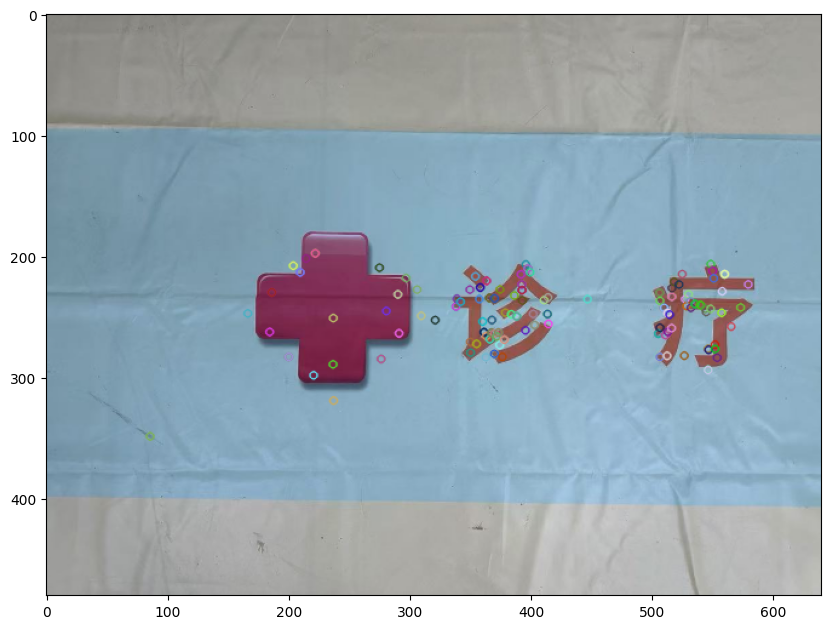

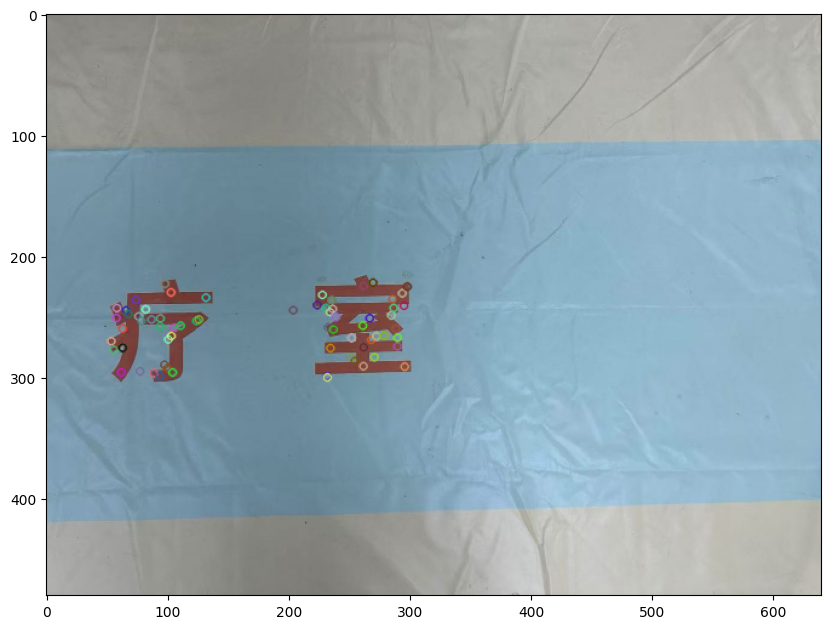

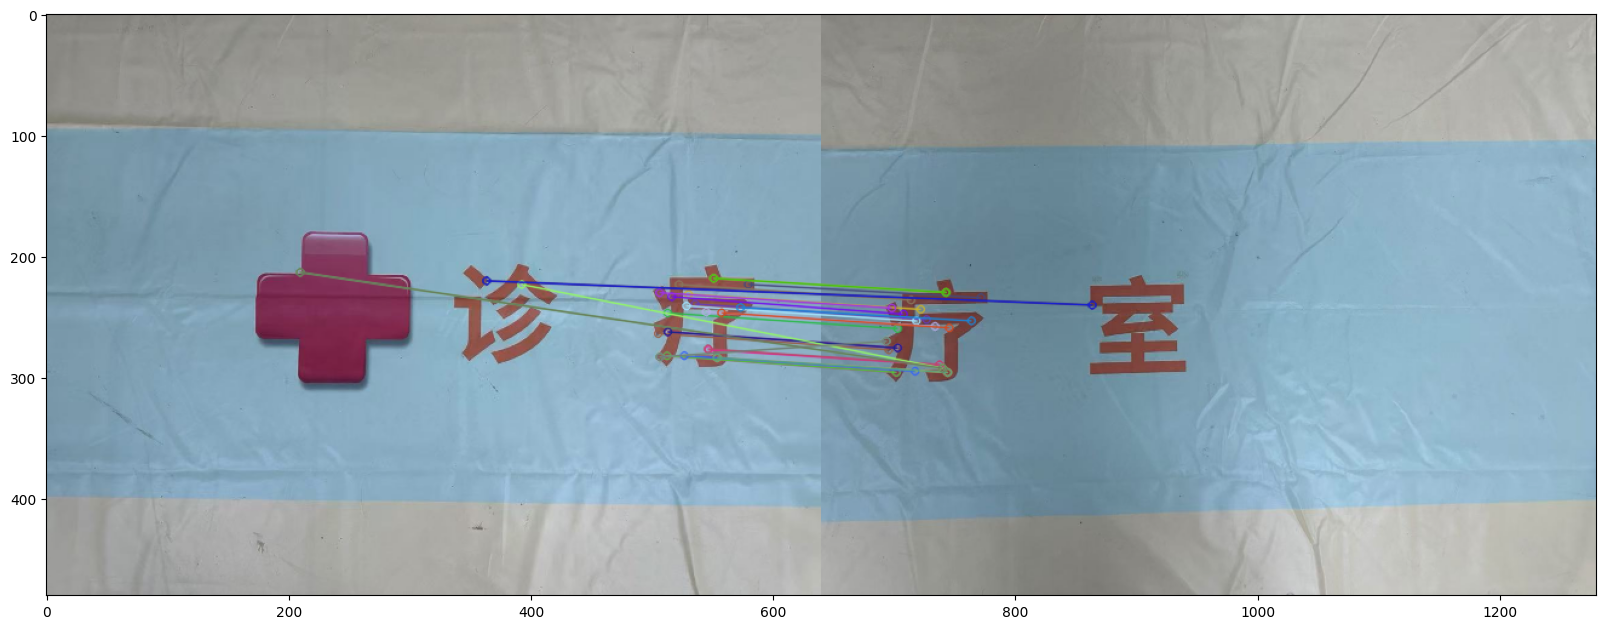

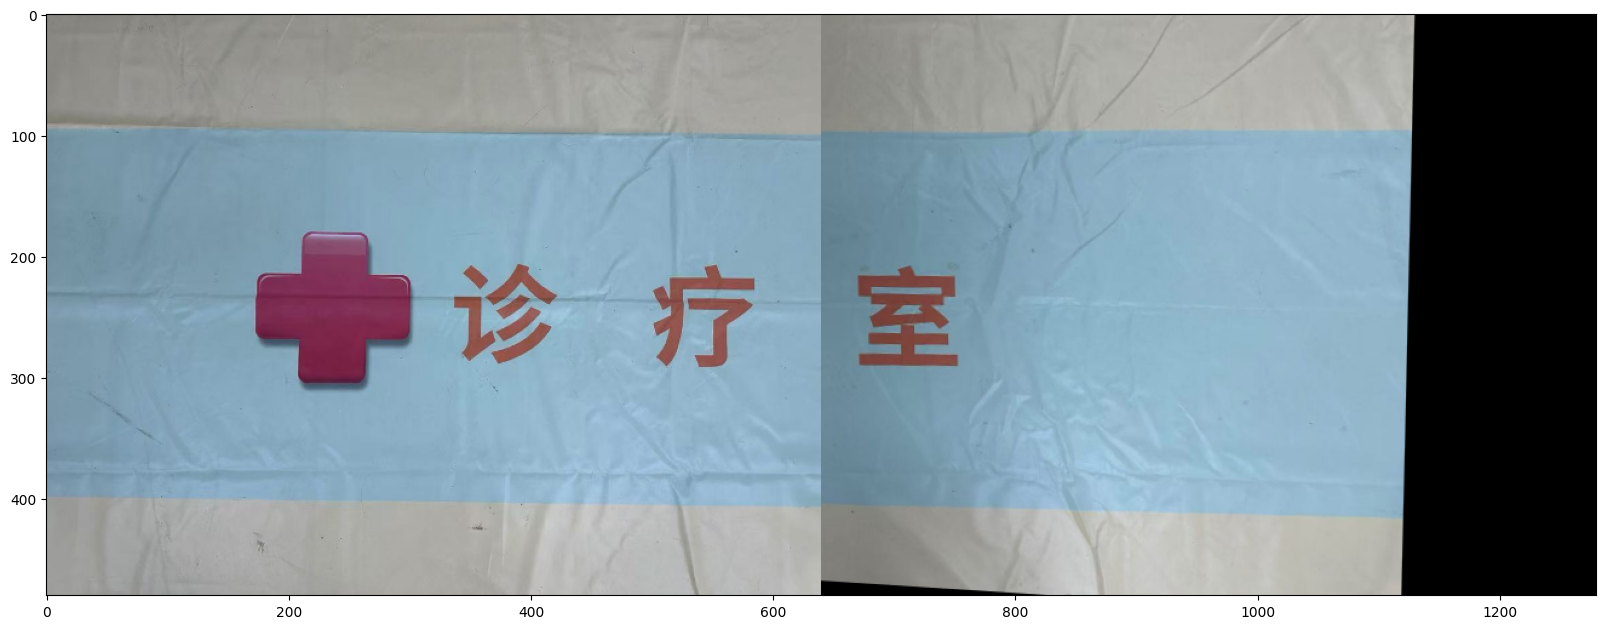

time: 0.84102463722229
FPS: 1.1890258094016946


True

In [783]:
img_left = cv2.imread('img/8.jpg')
img_right = cv2.imread('img/9.jpg')
time1 = time.time()
img = mian(img_left,img_right)    #面函数
time2 = time.time()
print("time:",time2-time1)
print("FPS:",1/(time2-time1))
cv2.imwrite('img/img.jpg', img)